In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

In [33]:
df = pd.read_csv(r"C://Users//Hiwi//Downloads//Data//raw_analyst_ratings.csv", parse_dates=['date'])
stock_data = pd.read_csv(r"C://Users//Hiwi//Downloads//Data//yfinance_data//AAPL_historical_data.csv", parse_dates=['Date'])
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
df.head()

Dataset shape: (1407328, 6)

Sample data:


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [34]:
df['sentiment'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [35]:
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date  # normalize to just date # Ensure 'date' column is in correct format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
daily_sentiment = df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)

In [36]:
def calculate_sentiment(text):
    if pd.isnull(text):
        return 0  # or np.nan if you prefer
    return TextBlob(str(text)).sentiment.polarity
df['Sentiment'] = df['headline'].apply(calculate_sentiment)

In [37]:
# For the news dataset
df['date'] = pd.to_datetime(df['date']).dt.date
# For the stock dataset
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

In [38]:
stock_data['Return'] = stock_data['Close'].pct_change()

In [39]:
merged_data = pd.merge(stock_data, daily_sentiment, on='Date', how='inner')
print(merged_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Return', 'sentiment'],
      dtype='object')


In [40]:
daily_sentiment = df.groupby('date')['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)

In [41]:
merged_data = pd.merge(stock_data, daily_sentiment, on='Date', how='inner')

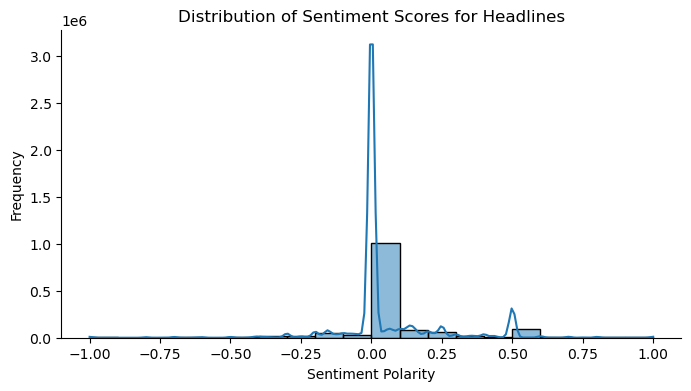

In [48]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Sentiment'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores for Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

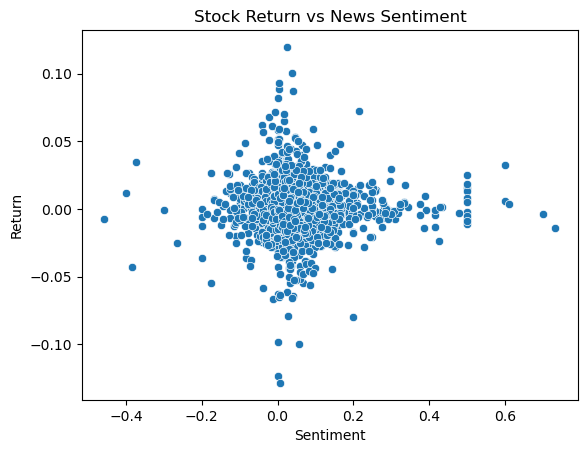

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=merged_data, x='Sentiment', y='Return')
plt.title('Stock Return vs News Sentiment')
plt.show()

In [51]:
# Analyze the sentiment of the most positive and negative headlines
most_positive_headlines = df.nlargest(5, 'Sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'Sentiment']])

most_negative_headlines = df.nsmallest(5, 'Sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'Sentiment']])


Most Positive Headlines:
                                               headline  Sentiment
819            Best Buy: Analysts' Upgrades, Downgrades        1.0
1343    OneMove(TM) Records its Best Month Ever in July        1.0
1382  Klondike Silver Completes Underground Drilling...        1.0
1849                             10 Best Stocks Of 2017        1.0
2270          Miners: The Best Way To Play A Rate Hike?        1.0

Most Negative Headlines:
                                               headline  Sentiment
2552  Tech, Semiconductors Among Worst Performers As...       -1.0
3175               I've just made a horrible investment       -1.0
5658   Worst Performing Industries For October 13, 2016       -1.0
5710   Worst Performing Industries For December 2, 2014       -1.0
6100                            10 Worst Stocks Of 2017       -1.0


In [52]:
result = stock_data[df['stock'] == "AAPL"]
print(result)

            Date      Open      High       Low     Close  Adj Close  \
6680  2007-06-05  4.336071  4.381786  4.303571  4.381071   3.699705   
6681  2007-06-06  4.367857  4.430357  4.355357  4.415714   3.728961   
6682  2007-06-07  4.463929  4.557500  4.399643  4.431071   3.741930   
6683  2007-06-08  4.493571  4.493929  4.367500  4.446071   3.754597   
6684  2007-06-11  4.500000  4.505357  4.269286  4.292500   3.624910   
...          ...       ...       ...       ...       ...        ...   
7116  2009-02-26  3.285714  3.318571  3.177143  3.185357   2.689955   
7117  2009-02-27  3.140357  3.260714  3.131071  3.189643   2.693574   
7118  2009-03-02  3.147143  3.257143  3.131071  3.140714   2.652255   
7119  2009-03-03  3.176071  3.240714  3.138571  3.156071   2.665224   
7120  2009-03-04  3.220714  3.313214  3.194643  3.256071   2.749671   

          Volume  Dividends  Stock Splits    Return  
6680   920785600        0.0           0.0  0.011044  
6681  1112241200        0.0           0

C:\Users\Hiwi\AppData\Local\Temp\ipykernel_1440\1099591011.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = stock_data[df['stock'] == "AAPL"]
